In [15]:
from scipy.stats import invwishart

import jax.numpy as jnp
import numpy as np

import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

import matplotlib.pyplot as plt

In [16]:
class InverseWishart(tfd.TransformedDistribution):
    """
    Inverse Wishart distribution over positive definite matrices.
    
    If W ~ Wishart(df, Psi^{-1}), then Sigma = W^{-1} ~ InverseWishart(df, Psi).
    
    Args:
        df: Degrees of freedom (must be > dimension - 1).
        scale: Scale matrix (Psi), must be positive definite and symmetric.
    """
    
    def __init__(self, df, scale, **kwargs):
        # Convert parameters to JAX arrays for consistency.
        self._df = jnp.asarray(df)
        self._scale = jnp.asarray(scale)
        
        # The Inverse Wishart is implemented by transforming a Wishart whose scale is Psi^{-1}.
        # The WishartTriL distribution requires a Cholesky factor of its scale matrix, so we compute:
        # L = chol((Psi)^{-1})
        wishart_scale_tril = jnp.linalg.cholesky(jnp.linalg.inv(self._scale))

        # Define the base Wishart distribution W ~ Wishart(df, Psi^{-1})
        base_dist = tfd.WishartTriL(df=self._df, scale_tril=wishart_scale_tril)
        
        # Bijector converting a Wishart-distributed matrix W into an
        # Inverse Wishart-distributed matrix Sigma = W^{-1}.
        #
        # Steps (applied from right to left):
        #   1. CholeskyOuterProduct(): Convert lower-triangular Cholesky factor
        #      to the full positive-definite matrix W.
        #   2. CholeskyToInvCholesky(): Convert W to its inverse via the
        #      Cholesky factor of W^{-1}.
        #   3. CholeskyOuterProduct(): Convert the Cholesky factor of W^{-1}
        #      back to the full matrix Sigma = W^{-1}.
        bijector = tfb.Chain([
            tfb.CholeskyOuterProduct(),
            tfb.CholeskyToInvCholesky(),
            tfb.Invert(tfb.CholeskyOuterProduct())
        ])
        
        # Initialize parent class
        super().__init__(
            distribution=base_dist,
            bijector=bijector,
            **kwargs
        )
        
        # Register parameters so that TFP can serialize this distribution
        self._parameters = dict(df=self._df, scale=self._scale)
    
    @property
    def df(self):
        """Degrees of freedom parameter."""
        return self._df
    
    @property
    def scale(self):
        """Scale matrix parameter."""
        return self._scale

In [17]:
# Setup: Construct inverse Wishart distribution
# Take example from page 138 of Rossi et al. (2006)

matrix_size = 5
df = float(matrix_size + 3 )                  # Degrees of freedom (8 in example)
scale = df * jnp.identity(matrix_size)  # Scale matrix (5x5 identity scaled by df)

print("Wishart Distribution Setup")
print(f"Degrees of freedom: {df}")
print(f"Scale matrix:\n{scale}\n")

# Create TensorFlow Probability and SciPy Inverse Wishart distributions
iw_tfp = InverseWishart(df=df, scale=scale)
iw_scipy = invwishart(df=df, scale=scale)

Wishart Distribution Setup
Degrees of freedom: 8.0
Scale matrix:
[[8. 0. 0. 0. 0.]
 [0. 8. 0. 0. 0.]
 [0. 0. 8. 0. 0.]
 [0. 0. 0. 8. 0.]
 [0. 0. 0. 0. 8.]]



In [19]:
# Compare tfp.Class probability comparison with SciPy
print("=" * 35)
print("TEST 1: Log Probability comparison")
print("=" * 35)

# Create a random positive definite matrix (ensure it's PD by constructing as A*A^T)
mat = np.random.rand(matrix_size, matrix_size)
random_pd_mat = jnp.dot(mat, mat.transpose())

print(f"Random matrix:\n{random_pd_mat}\n")

# Compute log probability using TFP and SciPy
lp_tfp = iw_tfp.log_prob(random_pd_mat)
lp_scipy = iw_scipy.logpdf(random_pd_mat)

print(f"TFP log probability:   {lp_tfp}")
print(f"SciPy log probability: {lp_scipy}")
print(f"Log probabilities match: {jnp.allclose(lp_tfp, lp_scipy)}\n")

TEST 1: Log Probability comparison
Random matrix:
[[1.8422059  0.669025   1.4870875  1.1134998  0.5658039 ]
 [0.669025   0.52948827 0.91096854 0.50476545 0.4159464 ]
 [1.4870875  0.91096854 2.2617383  1.0970263  1.0821903 ]
 [1.1134998  0.50476545 1.0970263  1.0604934  0.40377268]
 [0.5658039  0.4159464  1.0821903  0.40377268 0.6582098 ]]

TFP log probability:   -55.44147872924805
SciPy log probability: -55.44143590437806
Log probabilities match: True



In [20]:
# ----------------------------
# CONFIGURATION
# ----------------------------
num_trials = 5000          # number of PD matrices to generate
matrix_size = 5            # matrix dimension
output_file = "logprob_results.npz"

# ----------------------------
# STORAGE ARRAYS
# ----------------------------
matrices = np.zeros((num_trials, matrix_size, matrix_size))
tfp_logps = np.zeros(num_trials)
scipy_logps = np.zeros(num_trials)

# ----------------------------
# SIMULATION LOOP
# ----------------------------
for i in range(num_trials):
    # Create a random positive definite matrix
    mat = np.random.rand(matrix_size, matrix_size)
    pd_mat = mat @ mat.T

    # Save matrix
    matrices[i] = pd_mat

    # Compute log-probabilities
    tfp_logps[i] = float(iw_tfp.log_prob(jnp.array(pd_mat)))
    scipy_logps[i] = float(iw_scipy.logpdf(pd_mat))

    if i % 500 == 0:
        print(f"Generated {i}/{num_trials} matrices...")

# ----------------------------
# SAVE RESULTS TO DISK
# ----------------------------
np.savez(output_file, 
         matrices=matrices, 
         tfp_logps=tfp_logps, 
         scipy_logps=scipy_logps)

print(f"\nSaved results to: {output_file}")


Generated 0/5000 matrices...
Generated 500/5000 matrices...
Generated 1000/5000 matrices...
Generated 1500/5000 matrices...
Generated 2000/5000 matrices...
Generated 2500/5000 matrices...
Generated 3000/5000 matrices...
Generated 3500/5000 matrices...
Generated 4000/5000 matrices...
Generated 4500/5000 matrices...

Saved results to: logprob_results.npz


In [26]:
# ----------------------------
# LOAD SAVED RESULTS
# ----------------------------
data = np.load("logprob_results.npz")
matrices = data["matrices"]
tfp_logps = data["tfp_logps"]
scipy_logps = data["scipy_logps"]

# ----------------------------
# ANALYSIS SETUP
# ----------------------------
differences = tfp_logps - scipy_logps
abs_diff = np.abs(differences)

print("Loaded:")
print("  Matrices:", matrices.shape)
print("  TFP logps:", tfp_logps.shape)
print("  SciPy logps:", scipy_logps.shape)

Loaded:
  Matrices: (5000, 5, 5)
  TFP logps: (5000,)
  SciPy logps: (5000,)


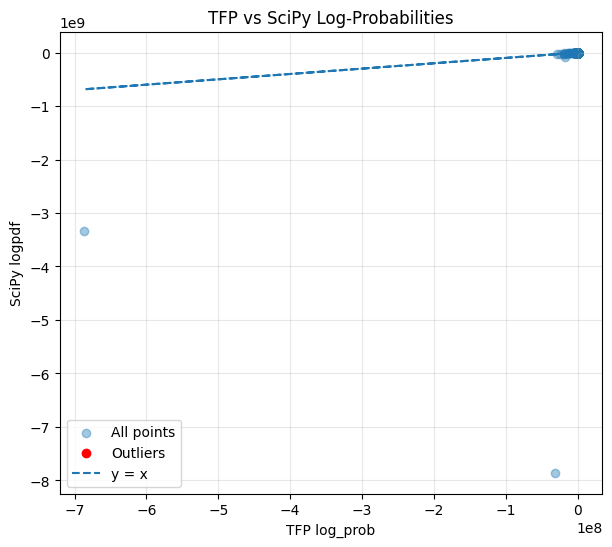

In [27]:
# ============================
# 1. SCATTER PLOT
# ============================
plt.figure(figsize=(7,6))
plt.scatter(tfp_logps, scipy_logps, alpha=0.4, label="All points")

# highlight outliers (|diff| > threshold)
threshold = np.percentile(abs_diff, 50)  # top 0.5% as outliers
mask = abs_diff > threshold
plt.scatter(tfp_logps[mask], scipy_logps[mask], color="red", label="Outliers")

plt.plot(tfp_logps, tfp_logps, "--", label="y = x")
plt.xlabel("TFP log_prob")
plt.ylabel("SciPy logpdf")
plt.title("TFP vs SciPy Log-Probabilities")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Seems liek there are 2 heavy outliers visible, where the implemented IW class values deviate alot form the scipy values

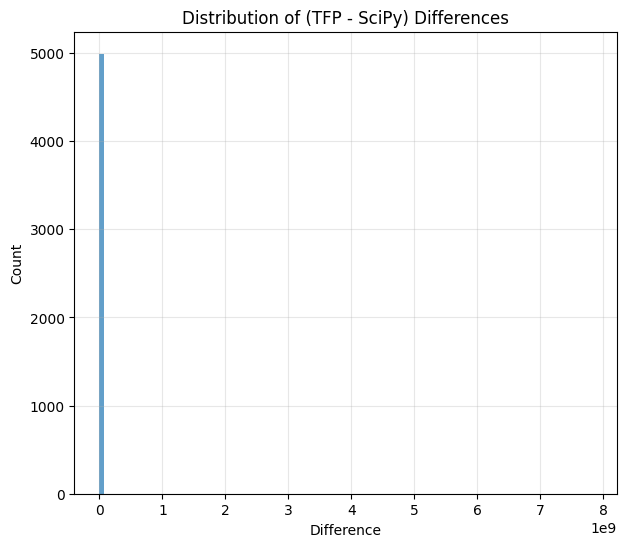

In [23]:
# ============================
# 2. HISTOGRAM OF DIFFERENCES
# ============================
plt.figure(figsize=(7,6))
plt.hist(differences, bins=100, alpha=0.7)
plt.title("Distribution of (TFP - SciPy) Differences")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

In [24]:
# ============================
# 4. OUTLIER DETECTION
# ============================
print("\nTop 10 most extreme:")
worst = np.argsort(abs_diff)[-10:]
for i in worst:
    print(f"Index {i}: diff={differences[i]:.6f}, TFP={tfp_logps[i]:.6f}, SciPy={scipy_logps[i]:.6f}")


Top 10 most extreme:
Index 3416: diff=64734689.416745, TFP=-17342948.000000, SciPy=-82077637.416745
Index 4671: diff=2642862814.033117, TFP=-686212544.000000, SciPy=-3329075358.033117
Index 1429: diff=7822546060.594142, TFP=-31676164.000000, SciPy=-7854222224.594142
Index 4053: diff=nan, TFP=nan, SciPy=-2129893171.401968
Index 1778: diff=nan, TFP=nan, SciPy=-312298214.220464
Index 538: diff=nan, TFP=nan, SciPy=-1214531753.778957
Index 4036: diff=nan, TFP=nan, SciPy=-62617141.237657
Index 917: diff=nan, TFP=nan, SciPy=-1774784258.439365
Index 127: diff=nan, TFP=nan, SciPy=-98105233.071737
Index 2601: diff=nan, TFP=nan, SciPy=-212289360.918916


## TFP NaN analysis

In [25]:
nan_idx = np.where(np.isnan(tfp_logps))[0]

print(f"\nFound {len(nan_idx)} NaN outputs from TFP.\n")
print("First few NaN indices:", nan_idx[:10])


Found 7 NaN outputs from TFP.

First few NaN indices: [ 127  538  917 1778 2601 4036 4053]


In [ ]:
for i in nan_idx[:10]:
    print(f"\n=== Matrix at index {i} ===")
    M = matrices[i]
    print("Matrix:\n", M)

    # Eigenvalues
    eigvals = np.linalg.eigvalsh(M)
    print("Eigenvalues:", eigvals)

    # Condition number
    cond = eigvals.max() / eigvals.min()
    print("Condition number:", cond)

    # Determinant
    print("Determinant:", np.linalg.det(M))

    # Try Cholesky in NumPy
    try:
        np.linalg.cholesky(M)
        print("NumPy Cholesky: OK")
    except np.linalg.LinAlgError:
        print("NumPy Cholesky: FAILED")

    # Try Cholesky in JAX
    try:
        jnp.linalg.cholesky(M)
        print("JAX Cholesky: OK")
    except Exception:
        print("JAX Cholesky: FAILED")



=== Matrix at index 153 ===
Matrix:
 [[2.36054158 1.12690595 1.6439908  1.36008723 1.60997558]
 [1.12690595 1.02874328 1.13267936 0.54788739 1.27313563]
 [1.6439908  1.13267936 1.58518209 0.7112674  1.57281796]
 [1.36008723 0.54788739 0.7112674  1.09947136 0.72330986]
 [1.60997558 1.27313563 1.57281796 0.72330986 1.66502708]]
Eigenvalues: [1.98831798e-07 4.37542635e-02 2.18483675e-01 9.66476494e-01
 6.51025076e+00]
Condition number: 32742503.116587434
Determinant: 1.1959533001890122e-08
NumPy Cholesky: OK
JAX Cholesky: OK

=== Matrix at index 310 ===
Matrix:
 [[3.56631882 2.17493254 1.81537051 2.32918927 2.49470874]
 [2.17493254 1.97063476 1.42733982 1.32377855 0.98661846]
 [1.81537051 1.42733982 1.50701868 1.02387158 1.12533038]
 [2.32918927 1.32377855 1.02387158 1.5903769  1.65552238]
 [2.49470874 0.98661846 1.12533038 1.65552238 2.24289284]]
Eigenvalues: [4.96520937e-10 2.93182092e-02 4.27951634e-01 1.27632593e+00
 9.14364623e+00]
Condition number: 18415429331.2021
Determinant: 7.2

Looks like teh InverseWishart class is strugglign when the input matrix has a determinant very close to 0/ the log-prob is large and negative.